## Part 1: Image segmentation exploration

In [1]:
import sys
print(sys.prefix)

from random import randint
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
print(torch.__version__)
from torchvision import transforms, datasets, models

# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# from pycocotools.coco import COCO


/Users/clairegong/Federated-Learning-PyTorch/fl
1.7.1


### 1. Examine COCO datasets with pycocotools

In [2]:
%cd '/Users/clairegong/Federated-Learning-PyTorch'
path2data = './data/coco/val2017'
path2ann = './data/coco/annotations/instances_val2017.json'


mean = [0.485, 0.456, 0.406]  
std = [0.229, 0.224, 0.225]
# mask less noise after normalizing input image, can check 'master_project/out' folder
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

# total 5000 from 2017 val dataset
data = datasets.CocoDetection(path2data, path2ann, transform=trans)
# create a instance of coco annotations file, to use pycocotools methods in following cells
coco = data.coco # SAME as data.coco

/Users/clairegong/Federated-Learning-PyTorch
loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


In [3]:
# USE pycocotools to examine img categories and annotations
catIds = coco.getCatIds()
cats = coco.loadCats(catIds)
cats = [cat['name'] for cat in cats]
print(len(cats) ,' categories are: \n', cats)

annIds = coco.getAnnIds()
ann = coco.loadAnns(annIds[0])[0]
print('\n annotation labels are: ', ann.keys())
print('\n', ann)

# img info only
imgIds = coco.getImgIds()
cocoImg = coco.loadImgs(imgIds[0])
print(cocoImg)

80  categories are: 
 ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

 annotation labels are:  dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 annotations for img idx 780
['person', 'skis']


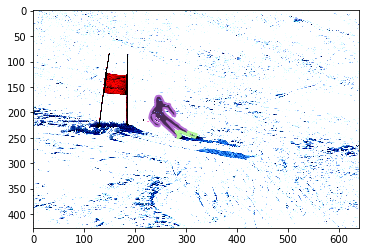

In [4]:
def show_random_img():
    # check annotations for image idx
    idx = randint(0,5000-1)
    img = data[idx][0]
    anns = data[idx][1]
    print(len(anns), 'annotations for img idx', idx)

    #show img and annotations
    img = data[idx][0]
    plt.imshow(img.permute(1,2,0))
    coco.showAnns(anns, draw_bbox=False)

    # check target catgories of the image
    catIds = [ann['category_id'] for ann in anns]
    cats = coco.loadCats(catIds)
    cat_names = [cat['name'] for cat in cats]
    print(cat_names)
    
show_random_img()

### 2. download segmentation models, inference

In [5]:
# download pretrained model on pascal 20 + 1 classes
fcn50 = models.segmentation.fcn_resnet50(pretrained=True)


def inference_img(model, idx):
    img = data[idx][0].unsqueeze(0)
    preds = model(img)['out']    
    print('Inference done on img idx {}, preds matrix size is {}'.format(idx, preds.size()))
    return preds

idx = randint(0, len(data)-1)
preds = inference_img(fcn50, idx)

Inference done on img idx 4155, preds matrix size is torch.Size([1, 21, 428, 640])


### 3. decode predictions into segmentation mask
make 1x21xHxW output into a HxW image with each pixel corresponds to a class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


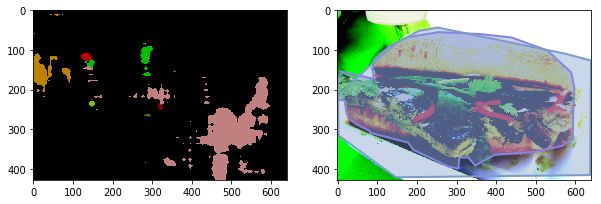

In [6]:
def rgb_mask(image, nc=21):
    '''
    convert 2d image with class labels to RGB image, where each label is mapped to color
    :params: image: HxW matrix
    :return: rgb: 3xHxW matrix
    ''' 
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def display_seg_map(preds, idx=idx):
    class_map = torch.argmax(preds.squeeze(), dim=0).detach().cpu().numpy()
    #print(class_map.shape)
    
    # Positive segmentation classes of total 20 pascal classes
    classes = np.unique(class_map)
    rgb = rgb_mask(class_map)
#     print(rgb.shape)
    
    # the seg mask is off because model is trained with 21 classes only, while truth has 80 classes
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(rgb)
    
    anns = data[idx][1]
    axs[1].imshow(data[idx][0].permute(1,2,0))
    coco.showAnns(anns)    

display_seg_map(preds)

### 4. finetune model into 80 class

In [7]:
num_classes = 81
fcn50_coco = copy.deepcopy(fcn50)
fcn50_coco.classifier[-1].out_channels = num_classes
fcn50_coco.aux_classifier[-1].out_channels = num_classes
print(fcn50_coco.classifier)
print(fcn50_coco.aux_classifier)

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 81, kernel_size=(1, 1), stride=(1, 1))
)
FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(256, 81, kernel_size=(1, 1), stride=(1, 1))
)


TODO: Change BACKBONE

### 5. train model with images
1. CLONE torchvision train and eval functions from github
2. make dataset loader
3. train and eval

In [11]:
%%bash
# git clone https://github.com/pytorch/vision.git
cd vision
cp -r references/segmentation/. ../gpu
cd ../gpu
ls

README.md
coco_utils.py
train.py
transforms.py
utils.py


### Self defined Cocodetection dataset

#### Data loader [DEBUG FIXED]
1. `RuntimeError: each element in list of batch should be of equal size` 
- due to `T.RandomResizedCrop(224)` larger than some min size       
2. no target from dataset:
- Redefine cocodataset, remove target transform
4. 25 Jan, add coco_utils ConvertPolygon2Mask  
`TypeError: __call__() missing 1 required positional argument: 'anno'`
5. use self-defined CocoDetection code, self.transform() takes in 2 arguments
6. add remap new bug: `TypeError: __call__() missing 1 required positional argument: 'target'`
- Reason: official `torchvision.transforms.Compose` takes in 1 arguments, we need 2 here, should use Compose() from `transforms.py`
7. **ROOT cause:** Cocodetection('transforms'=), NOT 'transform'. 
I was looking at a 0.4 old version of Cocodetection code...so comes all the confusion
- debug for two days SUCH a minor reason

 **READ DOC and keywords CAREFULLY**

In [12]:
from train import train_one_epoch, evaluate, criterion, get_transform
import utils
import torch.utils.data as data
from coco_utils import ConvertCocoPolysToMask, FilterAndRemapCocoCategories
from transforms import Compose

catIds.insert(0,0)
train_data = datasets.CocoDetection(path2data, path2ann, transforms=Compose([FilterAndRemapCocoCategories(catIds, remap=True), 
                                                                              ConvertCocoPolysToMask(),
                                                                              get_transform(train=True)]))
test_data = datasets.CocoDetection(path2data, path2ann, transforms=Compose([FilterAndRemapCocoCategories(catIds, remap=True), 
                                                                    ConvertCocoPolysToMask(),
                                                                    get_transform(train=False)]))

# # split train and test indice
torch.manual_seed(1)
idxs = torch.randperm(len(train_data)).tolist()
train_data = torch.utils.data.Subset(train_data, idxs[:4000])
test_data = torch.utils.data.Subset(test_data, idxs[4000:])

# following references.sementation.train.main setting
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4,\
                                        collate_fn=utils.collate_fn, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4,\
                                          collate_fn=utils.collate_fn)
print(len(train_data))
print(len(test_data))
print(len(train_loader))
print(len(test_loader)) 

# check IF loader works
img, target = iter(train_loader).next()
print(img.size())
print(target.size())
print(np.unique(target.numpy()))
# print(catIds)
# print(len(catIds))

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
4000
1000
1000
250


KeyboardInterrupt: 

In [ ]:
print(catIds)
print(len(catIds))

### **Train one epoch DEBUG[in progress]**

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
# train one epoch
import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fcn50_coco
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
epoches = 1
start = time.time()
for epoch in range(epoches):
    train_one_epoch(model, criterion, optimizer, train_loader, lr_scheduler, device, epoch, print_freq=1)
    train_time = time.time()-start
    print('train one epoch time(min) : ', train_time//60)
    lr_scheduler.step()
    confmat = evaluate(model, test_loader, device, num_classes=num_classes)
    print(confmat)
    print('eval time(min) : ', (time.time()-train_time)//60)


In [ ]:
targets = set()
for img, tar in train_loader:
    targets.add(tar)
print(targets)


In [ ]:
# change backbone to mobile net & train model again

### 6. evaluate result w.r.t groud truth masks

### 7. mask to segmentation annotations, then can use showAnns() to display results

## Part 2: Federated learning (E/Jan)

### 1. make non-iid sampler

### 2. (chanllenge)  federated model training with non-iid
add 'gpu' option for future experiments

### 3. after codebase can run, move to pysyft, add differential privacy

### 4. add argument parses, run experiments, conclude

## Part 3: Project demo, with streamlit (M/Feb)

## Final: Project report (E/Feb)